# Домашнее задание 2. Классификация изображений.

Блок 0: Библиотеки

In [ ]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics


from IPython.display import clear_output

import wandb

import math
import os
import random
import sys
import zipfile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

from PIL import Image

from tqdm import tqdm

clear_output()

Блок 1: Монтируем Google Drive для работы с датасетом (Папками Train и Val), также авторизируемся в WANDB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
wandb.login()

Mounted at /content/drive


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Блок 2: Монтируем сиды и переходим на CUDA

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('cuda available')
else:
    device = torch.device('cpu')

cuda available


Блок 3: Разархивируем датасеты в colab и проверяем файлы

In [ ]:
train_zip_path = '/content/drive/MyDrive/train.zip'
val_zip_path = '/content/drive/MyDrive/val.zip'

with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/train')

with zipfile.ZipFile(val_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/val')

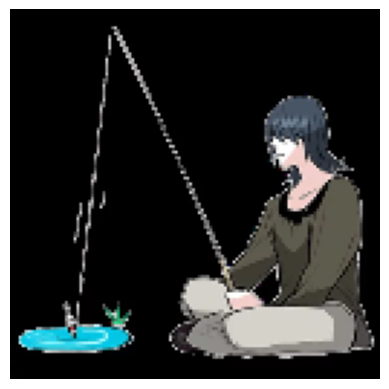

In [ ]:
train_folder = '/content/train/train/U+1F3A3'

def display_images(folder_path, n=1):
    images = os.listdir(folder_path)[:n]
    for img_name in images:
        img_path = os.path.join(folder_path, img_name)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

display_images(train_folder, n=1)

## Задание 0

# СОЗДАЁМ КАСТОМНЫЙ ДАТАСЕТ

In [ ]:
class CustomImageDataset(Dataset):

  def __init__(self, root_dir, transform = None):
    self.root_dir = root_dir
    self.transform = transform

    self.image_paths =[]
    self.labels = []
    self.class_names = sorted(os.listdir(root_dir))

    self.class_to_idx = {class_name: i for i, class_name in enumerate(self.class_names)}

    for class_name in self.class_names:
      class_dir = os.path.join(root_dir, class_name)
      for image_name in os.listdir(class_dir):
        self.image_paths.append(os.path.join(class_dir, image_name))
        self.labels.append(self.class_to_idx[class_name])

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    image = Image.open(image_path).convert("RGB")

    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

# СОЗДАЁМ КАСТОМНЫЙ DATALOADER

Даталоадер + аугментация для трейна

In [ ]:
train_dir = "/content/train/train"

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomImageDataset(root_dir = train_dir, transform = train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

Даталоадер + аугментация для валидации

In [ ]:
val_dir = "/content/val/val"

val_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_dataset = CustomImageDataset(root_dir = val_dir, transform = val_transforms)
val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle = False)

# СОЗДАЁМ ФУНКЦИЮ ПРОСМОТРА ЧАСТИ БАТЧА

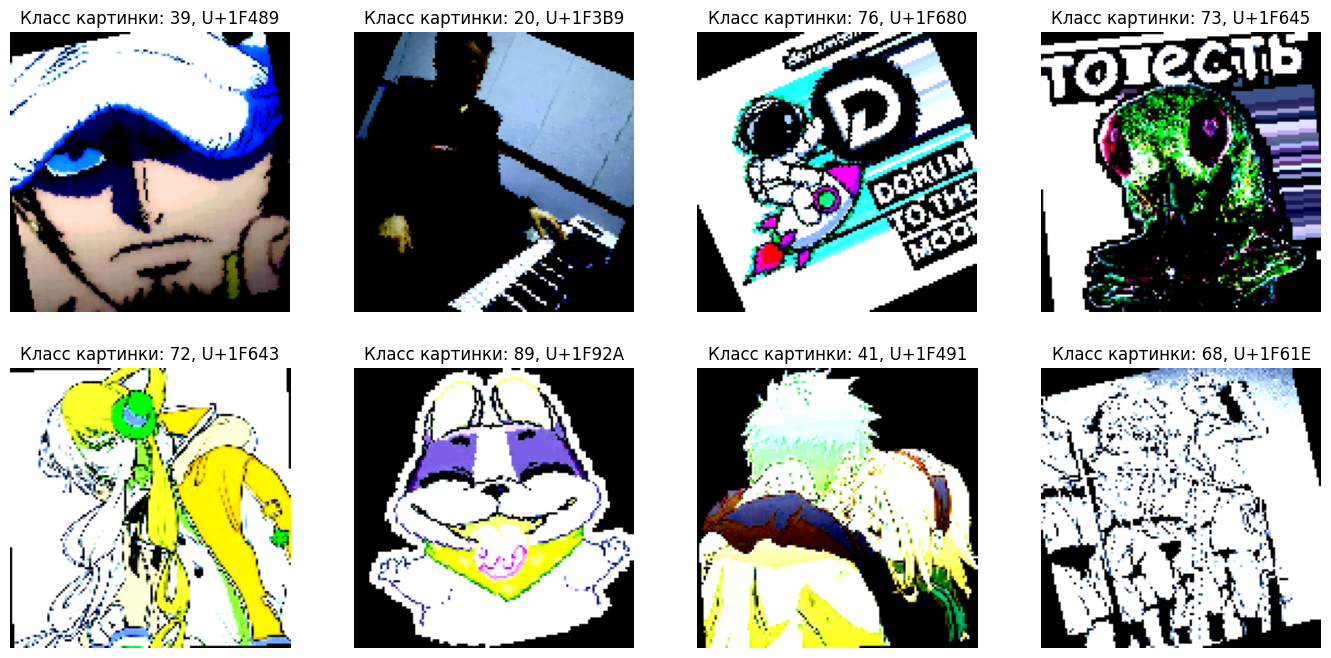

In [ ]:
import matplotlib.pyplot as plt

def show_batch(dataloader, class_names):
    for images, labels in dataloader:
        plt.figure(figsize=(17, 8))
        for i in range(8):
            plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title(f'Класс картинки: {labels[i].item()}, {class_names[labels[i].item()]}')
            plt.axis('off')
        break
show_batch(train_dataloader, train_dataset.class_names)

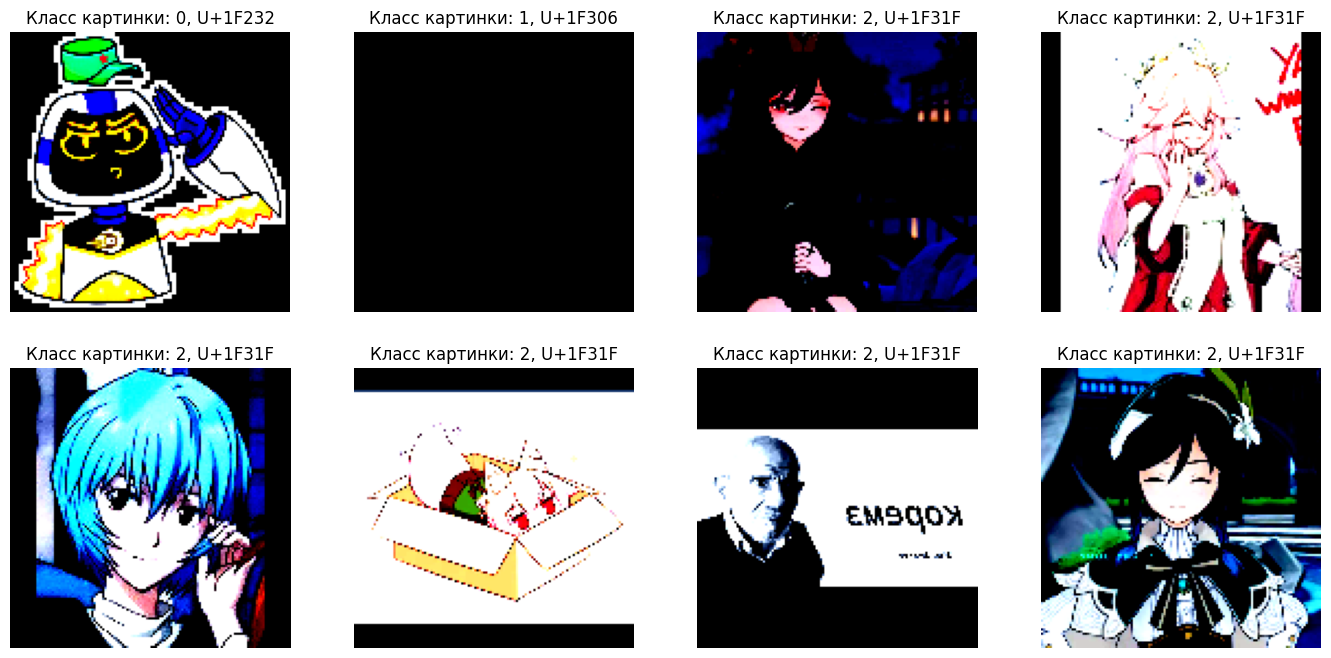

In [ ]:
import matplotlib.pyplot as plt

def show_batch(dataloader, class_names):
    for images, labels in dataloader:
        plt.figure(figsize=(17, 8))
        for i in range(8):
            plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title(f'Класс картинки: {labels[i].item()}, {class_names[labels[i].item()]}')
            plt.axis('off')
        break
show_batch(val_dataloader, val_dataset.class_names)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


## Задание 1.

5 баллов
Добейтесь accuracy на валидации не менее 0.4. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть ноутбуки прошедших семинаров и создайте из них что-то общее. Семинарских тетрадок хватит сверх

МОДЕЛЬ И ЦИКЛ ОБУЧЕНИЯ

Epoch [1/20], Train Loss: 3.7075, Val Loss: 3.5940, Accuracy: 0.1484
Epoch [2/20], Train Loss: 3.6099, Val Loss: 3.5566, Accuracy: 0.1496
Epoch [3/20], Train Loss: 3.5629, Val Loss: 3.5312, Accuracy: 0.1424
Epoch [4/20], Train Loss: 3.5222, Val Loss: 3.4707, Accuracy: 0.1604
Epoch [5/20], Train Loss: 3.4803, Val Loss: 3.4434, Accuracy: 0.1532
Epoch [6/20], Train Loss: 3.4359, Val Loss: 3.4341, Accuracy: 0.1680
Epoch [7/20], Train Loss: 3.3905, Val Loss: 3.4346, Accuracy: 0.1592
Epoch [8/20], Train Loss: 3.3379, Val Loss: 3.3804, Accuracy: 0.1676
Epoch [9/20], Train Loss: 3.2950, Val Loss: 3.3249, Accuracy: 0.1836
Epoch [10/20], Train Loss: 3.2393, Val Loss: 3.3196, Accuracy: 0.1912
Epoch [11/20], Train Loss: 3.1869, Val Loss: 3.2843, Accuracy: 0.1940
Epoch [12/20], Train Loss: 3.1307, Val Loss: 3.2654, Accuracy: 0.2000
Epoch [13/20], Train Loss: 3.0728, Val Loss: 3.2545, Accuracy: 0.2164
Epoch [14/20], Train Loss: 3.0163, Val Loss: 3.2605, Accuracy: 0.2072
Epoch [15/20], Train Loss: 2.

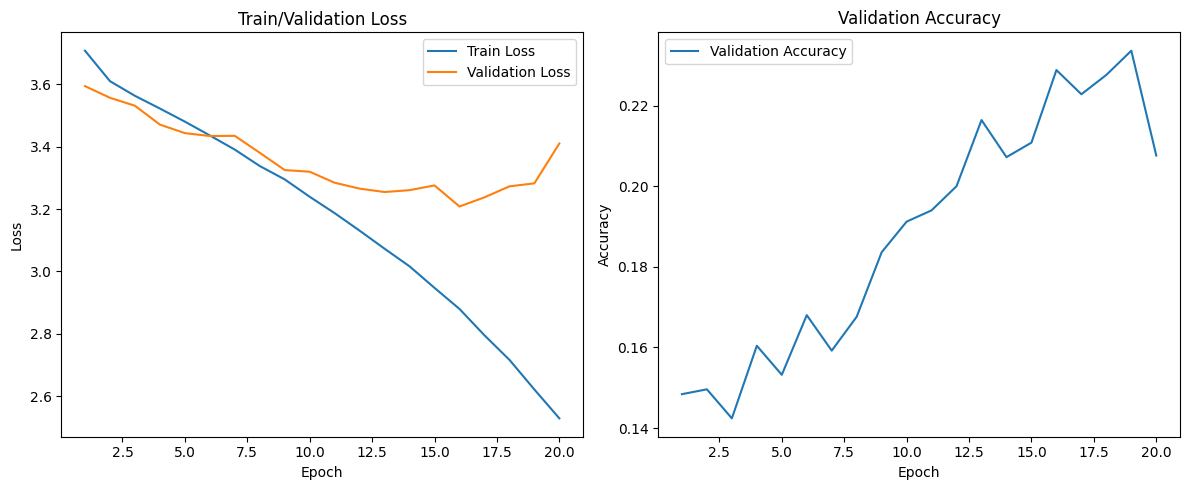

Accuracy,▁▂▁▂▂▃▂▃▄▅▅▅▇▆▆█▇██▆
Train Loss,█▇▇▇▇▆▆▆▆▅▅▅▄▄▃▃▃▂▂▁
Validation Loss,█▇▇▆▅▅▅▄▃▃▂▂▂▂▂▁▂▂▂▅
Accuracy,0.2076
Train Loss,2.52908
Validation Loss,3.41019


In [ ]:
seed_everything(123456)

wandb.init(project="image-classification", name="ResNet18-Experiment")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, 100)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / labels.size(0)

try:
    start_epoch, train_losses, val_losses, accuracies = load_checkpoint('checkpoint.pth')
except FileNotFoundError:
    print("No checkpoint found, starting training from scratch.")
    start_epoch = 0
    train_losses, val_losses, accuracies, log_metrics = [], [], [], []



num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss, val_loss, train_accuracy, val_accuracy = 0.0, 0.0, 0.0, 0.0
    total_train_samples, total_val_samples = 0, 0


    for inputs, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
        total_train_samples += inputs.size(0)


    train_loss /= total_train_samples
    train_accuracy /= total_train_samples
    train_losses.append(train_loss)


    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(val_dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
            total_val_samples += inputs.size(0)

    val_loss /= total_val_samples
    val_accuracy /= total_val_samples
    val_losses.append(val_loss)
    accuracies.append(val_accuracy)


    wandb.log({
        "Train Loss": train_loss,
        "Validation Loss": val_loss,
        "Accuracy": val_accuracy
    })


    scheduler.step(val_loss)

    log_metrics.append(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


    clear_output(wait=True)
    for log in log_metrics:
        print(log)

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, epoch+2), y=train_losses, label="Train Loss")
    sns.lineplot(x=range(1, epoch+2), y=val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train/Validation Loss")
    plt.legend()


    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, epoch+2), y=accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show(block=False)
    plt.pause(0.1)

wandb.finish()

In [ ]:
def save_checkpoint(model, optimizer, epoch, train_losses, val_losses, accuracies, log_metrics, filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'accuracies': accuracies,
        'log_metrics' : log_metrics,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch + 1}")

In [ ]:
save_checkpoint(model, optimizer, epoch, train_losses, val_losses, accuracies)

Checkpoint saved at epoch 20


In [ ]:
def load_checkpoint(filename='checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    accuracies = checkpoint['accuracies']
    print(f"Checkpoint loaded from epoch {start_epoch + 1}")
    return start_epoch, train_losses, val_losses, accuracies

In [ ]:
start_epoch, train_losses, val_losses, accuracies = load_checkpoint('checkpoint.pth')

Checkpoint loaded from epoch 20


<ipython-input-13-fd77ace0419c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


In [ ]:
seed_everything(123456)

wandb.init(project="image-classification", name="ResNet18-Experiment")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, 100)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / labels.size(0)

try:
    start_epoch, train_losses, val_losses, accuracies = load_checkpoint('checkpoint.pth')
except FileNotFoundError:
    print("No checkpoint found, starting training from scratch.")
    start_epoch = 0
    train_losses, val_losses, accuracies, log_metrics = [], [], [], []

log_metrics = []

num_epochs = 20
add_epochs = 10
for epoch in range(1, num_epochs):
    model.train()
    train_loss, val_loss, train_accuracy, val_accuracy = 0.0, 0.0, 0.0, 0.0
    total_train_samples, total_val_samples = 0, 0


    for inputs, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
        total_train_samples += inputs.size(0)


    train_loss /= total_train_samples
    train_accuracy /= total_train_samples
    train_losses.append(train_loss)


    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(val_dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
            total_val_samples += inputs.size(0)

    val_loss /= total_val_samples
    val_accuracy /= total_val_samples
    val_losses.append(val_loss)
    accuracies.append(val_accuracy)


    wandb.log({
        "Train Loss": train_loss,
        "Validation Loss": val_loss,
        "Accuracy": val_accuracy
    })


    scheduler.step(val_loss)

    log_metrics.append(f"Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


    clear_output(wait=True)
    for log in log_metrics:
        print(log)


wandb.finish()

Epoch [1/20], Train Loss: 2.2660, Val Loss: 3.3706, Accuracy: 0.2472
Epoch [2/20], Train Loss: 2.1451, Val Loss: 3.4633, Accuracy: 0.2336
Epoch [3/20], Train Loss: 2.0286, Val Loss: 3.5215, Accuracy: 0.2336
Epoch [4/20], Train Loss: 1.9343, Val Loss: 3.6169, Accuracy: 0.2344
Epoch [5/20], Train Loss: 1.8377, Val Loss: 3.6804, Accuracy: 0.2484
Epoch [6/20], Train Loss: 1.6397, Val Loss: 3.7635, Accuracy: 0.2476
Epoch [7/20], Train Loss: 1.5654, Val Loss: 3.8651, Accuracy: 0.2432
Epoch [8/20], Train Loss: 1.4838, Val Loss: 3.9703, Accuracy: 0.2384
Epoch [9/20], Train Loss: 1.4206, Val Loss: 4.0013, Accuracy: 0.2428
Epoch [10/20], Train Loss: 1.3210, Val Loss: 4.0839, Accuracy: 0.2452
Epoch [11/20], Train Loss: 1.2768, Val Loss: 4.1419, Accuracy: 0.2460
Epoch [12/20], Train Loss: 1.2349, Val Loss: 4.2058, Accuracy: 0.2396
Epoch [13/20], Train Loss: 1.1993, Val Loss: 4.2340, Accuracy: 0.2416
Epoch [14/20], Train Loss: 1.1488, Val Loss: 4.2645, Accuracy: 0.2468
Epoch [15/20], Train Loss: 1.

Accuracy,▇▁▁▁██▆▃▅▆▇▄▅▇█▆▆▇▅
Train Loss,█▇▇▆▆▄▄▄▃▃▂▂▂▂▁▁▁▁▁
Validation Loss,▁▂▂▃▃▄▄▅▅▆▆▇▇▇▇▇███
Accuracy,0.2424
Train Loss,1.0489
Validation Loss,4.41086


### Валидация результатов задания

In [ ]:
def evaluate_task(model, test_dataloader, criterion, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            acc_batch = (preds == labels).float().mean().item()
            accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [ ]:
seed_everything(1234567)

model = model.to(device)

accuracy = evaluate_task(model, val_dataloader, criterion)
print(f"Оценка за это задание составит {np.clip(5 * accuracy / 0.24, 0, 5):.2f} баллов")

100%|██████████| 40/40 [00:04<00:00,  9.61it/s]

Оценка за это задание составит 5.00 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.8. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры лучше используйте Adam c параметрами по умолчанию как стартовую точку.
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и создайте из них что-то общее. Семинарских тетрадок хватит сверх

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = CustomImageDataset(root_dir = train_dir, transform = train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

In [ ]:
val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_dataset = CustomImageDataset(root_dir = val_dir, transform = val_transforms)
val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle = False)

In [ ]:
from torchvision.models import efficientnet_b3

model = efficientnet_b3(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 100)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 118MB/s]


Epoch [1/30], Train Loss: 3.4301, Val Loss: 3.0749, Accuracy: 0.2416
Epoch [2/30], Train Loss: 3.1066, Val Loss: 2.9127, Accuracy: 0.2772
Epoch [3/30], Train Loss: 2.9198, Val Loss: 2.7890, Accuracy: 0.3088
Epoch [4/30], Train Loss: 2.7897, Val Loss: 2.7377, Accuracy: 0.3224
Epoch [5/30], Train Loss: 2.6706, Val Loss: 2.6704, Accuracy: 0.3416
Epoch [6/30], Train Loss: 2.5720, Val Loss: 2.6361, Accuracy: 0.3528
Epoch [7/30], Train Loss: 2.4819, Val Loss: 2.5989, Accuracy: 0.3664
Epoch [8/30], Train Loss: 2.3936, Val Loss: 2.6381, Accuracy: 0.3580
Epoch [9/30], Train Loss: 2.3088, Val Loss: 2.6296, Accuracy: 0.3756
Epoch [10/30], Train Loss: 2.2190, Val Loss: 2.6985, Accuracy: 0.3724
Epoch [11/30], Train Loss: 2.1473, Val Loss: 2.6897, Accuracy: 0.3588
Epoch [12/30], Train Loss: 1.8669, Val Loss: 2.7219, Accuracy: 0.3920
Epoch [13/30], Train Loss: 1.7253, Val Loss: 2.7658, Accuracy: 0.4048
Epoch [14/30], Train Loss: 1.6312, Val Loss: 2.9109, Accuracy: 0.3860


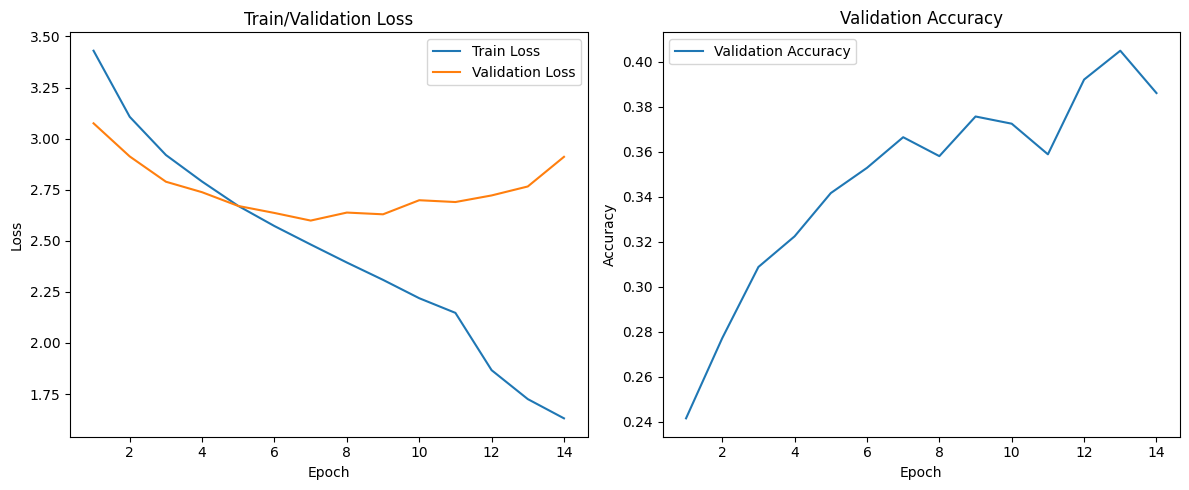

Training Epoch 15/30:  15%|█▍        | 104/713 [02:20<14:06,  1.39s/it]

In [ ]:
seed_everything(123456)

wandb.init(project="image-classification", name="efficientnet_b3-Experiment")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / labels.size(0)

train_losses, val_losses, accuracies, log_metrics = [], [], [], []


num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_loss, val_loss, train_accuracy, val_accuracy = 0.0, 0.0, 0.0, 0.0
    total_train_samples, total_val_samples = 0, 0


    for inputs, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
        total_train_samples += inputs.size(0)


    train_loss /= total_train_samples
    train_accuracy /= total_train_samples
    train_losses.append(train_loss)


    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(val_dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
            total_val_samples += inputs.size(0)

    val_loss /= total_val_samples
    val_accuracy /= total_val_samples
    val_losses.append(val_loss)
    accuracies.append(val_accuracy)


    wandb.log({
        "Train Loss": train_loss,
        "Validation Loss": val_loss,
        "Accuracy": val_accuracy
    })


    scheduler.step(val_loss)

    log_metrics.append(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


    clear_output(wait=True)
    for log in log_metrics:
        print(log)

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, epoch+2), y=train_losses, label="Train Loss")
    sns.lineplot(x=range(1, epoch+2), y=val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train/Validation Loss")
    plt.legend()


    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, epoch+2), y=accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show(block=False)
    plt.pause(0.1)

wandb.finish()

### Валидация результатов задания

In [ ]:
model = model.to(device)

accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(5 * (accuracy - 0.4) / 0.4, 0, 5):.2f} баллов")

NameError: name 'model' is not defined

In [ ]:
print(f"Оценка за это задание составит {np.clip(5 * (0.4048 - 0.24) / 0.1, 0, 5):.2f} баллов")

Оценка за это задание составит 5.00 баллов


# Отчёт об экспериментах



**ОТЧЁТ ОБ ЭКСПЕРИМЕНТАХ**

*Владислав Ретро ИАД-6*


---



**САМОЕ НАЧАЛО**

Ещё до того, как приступать к ресёрчу моделей, просмотру различных архитектур и обучению, я начал изучать датасет, сразу разбитый на два архива train.zip и  val.zip.

Проанализировал содержимое, полностью осознал задачу и приступил к написанию кастомных torch.Dataset и torch.DataLoader.

На этом месте определил аугментации для своего набора данных из torch.augmentations
В самом первом эксперименте игрался только со случайными флипами (аналогично на валидационной выборке). Что касаемо параметров Custom Dataloader — batch_size не подбирал, после экспериментов в ДЗ1 для задачи определил batch_size = 64, здесь он тоже хорошо себя показал.

**ЗАПУСК ПЕРВОЙ МОДЕЛИ**

После всех приготовлений и написания цикла обучения , я был готов приступать к моделям.

Моя первая — готовая архитектура ResNet18 без претрейна.

—————

*ResNet18 работает следующим образом:*

*Начальный слой. Конволюционный слой, который служит точкой входа для входных данных.*

*Residual блоки. Три остаточных блока с увеличивающимся числом каналов для более глубокого извлечения признаков.*

*Финальная обработка. Выход из последнего остаточного блока усредняется, в результате чего получается сплющенный вектор признаков, который затем обрабатывается полностью связанной нейронной сетью.*

—————

В качестве оптимизатора использовал Adam с learning rate = 0.001


**И-ИИ... РЕЗУЛЬТАТ**

Первые 20 эпохи успешно завершились, а вот результаты были далеко не удовлетворительными. Accuracy под конец начал снижаться, а val_loss, наоборот, ушёл далеко вверх.

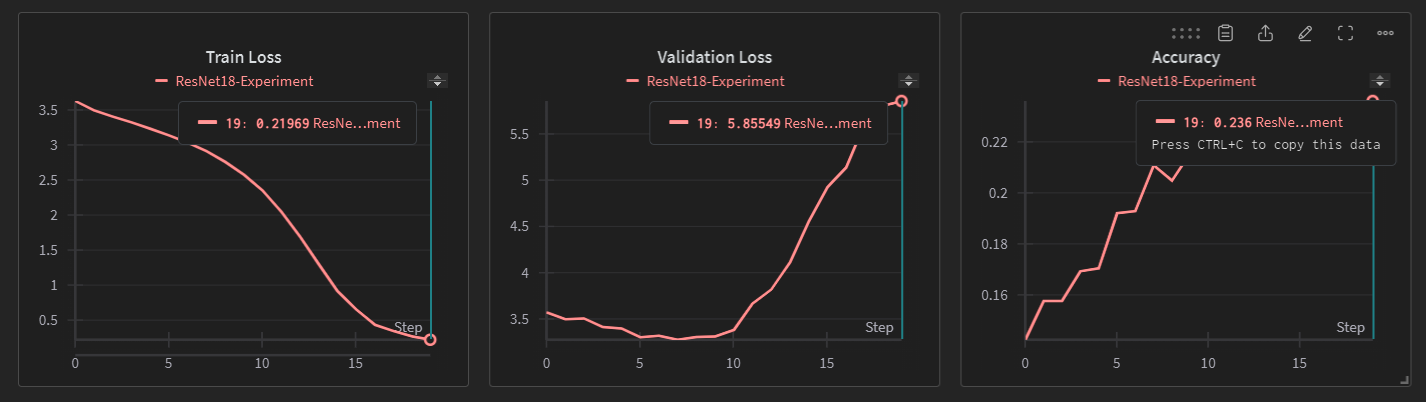

На этом этапе, я решил, что заострю внимание на двух переменных: аугментациях и архитектуре модели.

Добавил несколько новых аугментаций: normalize, random rotate, color jitter. Также, решил немного уменьшить вероятность переобучения модели и к действующей архитектуре ResNet18 добавил DropOut с вероятностью в 30% перед выходным слоем.

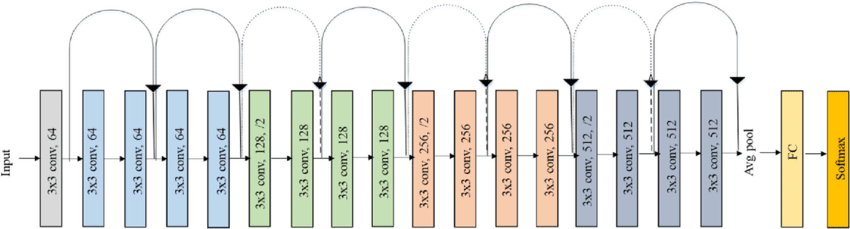

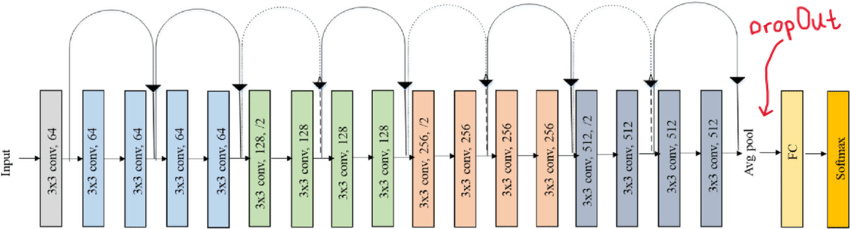

Эти действия дали очень хороший результат, который удовлетворяет критериям оценки, что показано на графика ниже.

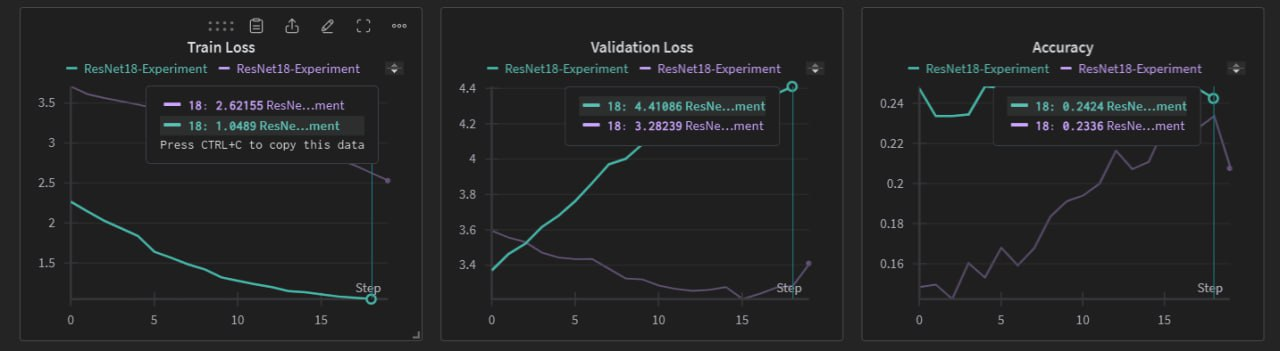

Однако, можно заметить, что линий графиков две, это связано с тем, что первых 20-ти эпохи мне не хватило для достаточного обучения, поэтому я создал чекпоинт и продолжил обучать модель с 21-й эпохи (всего 40).

Сразу же после первой эпохи чекпонта (21-я эпоха) мне выбила Accuracy в 0.24, но мне было интересно проследить за тенденцией роста.


**ЗАДАНИЕ ДВА. ПРЕТРЕЙН**

Т.к. подойдя к данному этапу, я уже проделал большой ресёрч по архитектурам и аугментациям, мне не составило труда чуть обновить блоки transform и импортнуть новую предобученную модель, что выдало мне хороший результат даже без моего вмешательства в архитектуру нейронной сети.

Моей моделью выступила — efficientnet_b3

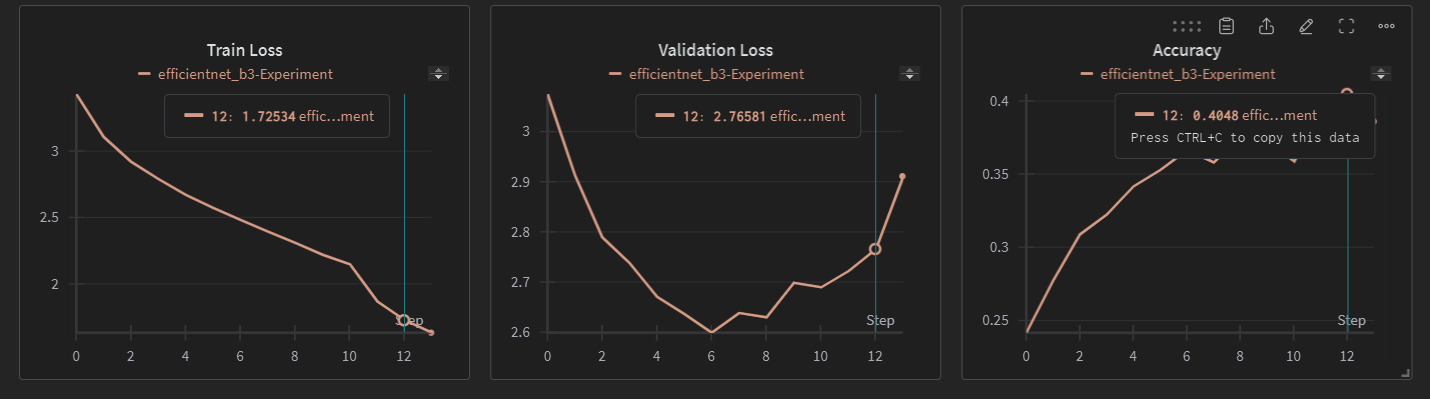



—————

**ОБЩИЕ НАБЛЮДЕНИЯ**

Google запрещает подключиться к другому диску, нежели аунтефицированном в текущей сессии colab. :(

При обучении на ResNet18, видеопамять была 1.5 / 15 Гб, а при обучении на efficientnet_b3 видеопамять уже составляла 14.7 / 15 Гб